In [1]:
import sys,os

import pyglet
pyglet.options['shadow_window'] = False

import pyrender
import numpy as np
import trimesh
import random
import time

from scipy.sparse.linalg import eigs
from mpl_toolkits import mplot3d



%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

print('Done!')

Done!


# Point Cloud Generation

Here, we randomly generate a 5000-vertex point cloud of three intersecting planes at a set angle.

In [2]:
# Control variables

# Scale changes size
# Degrees changes angles of the walls
# Rotator changes the point cloud's entire rotation
# NoiseSigma changes the intensity of the noise applied
scale = 8
degrees = 60
rotator = 90

noisesigma = 0.01

# Ensures we get 5000 points total
# maxiter1 is for initial wall generation
# maxiter2 is for rotation merging between Wall 1 and Wall 2 (the two vertical walls)
maxiter1 = 1249
maxiter2 = 625

# Sets vertices as blank so that we can refer to it outside of functions
vertices = np.zeros([5000,6])

In [12]:
def generatecloud():
    global vertices
    
    # Generates random points in the point cloud, starting with simple 90-degree planes
    # First 3 columns are x-y-z coordinates
    # Last 3 columns are x-y-z normal vectors

    wall1 = np.array([[1.,1.,0.,0.,0.,1.]])
    wall2 = np.array([[0.,1.,1.,1.,0.,0.]])
    wall3 = np.array([[1.,0.,1.,0.,1.,0.]])

    for i in range(maxiter1):

        r1 = random.uniform(0., 1.)
        r2 = random.uniform(0., 1.)
        r3 = random.uniform(0., 1.)
        r4 = random.uniform(0., 1.)
        r5 = random.uniform(0., 1.)
        r6 = random.uniform(0., 1.)

        wall1 = np.append(wall1, [[r1, r2, 0., 0., 0., 1.]], axis=0)
        wall2 = np.append(wall2, [[0., r3, r4, 1., 0., 0.]], axis=0)
        wall3 = np.append(wall3, [[r5, 0., r6, 0., 1., 0.]], axis=0)

    rotate1 = Rotation.from_euler('x', -degrees, degrees=True)
    rotate2 = Rotation.from_euler('z', degrees, degrees=True)

    # Calculates the point where the two walls would meet when rotated
    minval = np.dot(rotate1.as_matrix(), np.array(wall1[0,:3]).T)[2]

    temp1 = np.zeros([1,6])
    temp2 = np.zeros([1,6])

    # Adds more points to the pointcloud to merge the walls together
    for i in range(maxiter2):

        r1 = random.uniform(minval, 0.)
        r4 = random.uniform(minval, 0.)

        min1 = (r1 / minval)
        min2 = (r4 / minval)
        r2 = random.uniform(min1, 1.)
        r3 = random.uniform(min2, 1.)

        temp1 = np.append(temp1, [[r1, r2, 0., 0., 0., 1.,]], axis=0)
        temp2 = np.append(temp2, [[0., r3, r4, 1., 0., 0.,]], axis=0)

    # Rotates the walls to join together
    walljoint1 = np.dot(rotate1.as_matrix(), np.array(temp1[1:,:3]).T).T
    walljoint2 = np.dot(rotate2.as_matrix(), np.array(temp2[1:,:3]).T).T
    walljointnormals1 = np.dot(rotate1.as_matrix(), np.array(temp1[1:,3:]).T).T
    walljointnormals2 = np.dot(rotate2.as_matrix(), np.array(temp2[1:,3:]).T).T

    walljoint1 = np.append(walljoint1, walljointnormals1, axis=1)
    walljoint2 = np.append(walljoint2, walljointnormals2, axis=1)

    # --------- #

    # Merges all of the points together for a single point cloud file

    rotatedWall1 = np.dot(rotate1.as_matrix(), np.array(wall1[:,:3]).T).T
    rotatedWall2 = np.dot(rotate2.as_matrix(), np.array(wall2[:,:3]).T).T

    rotatedNormals1 = np.dot(rotate1.as_matrix(), np.array(wall1[:,3:]).T).T
    rotatedNormals2 = np.dot(rotate2.as_matrix(), np.array(wall2[:,3:]).T).T

    rotatedWall1 = np.append(rotatedWall1, rotatedNormals1, axis=1)
    rotatedWall2 = np.append(rotatedWall2, rotatedNormals2, axis=1)

    fullwall1 = np.append(rotatedWall1, walljoint1, axis=0)
    fullwall2 = np.append(rotatedWall2, walljoint2, axis=0)

    fullwall3 = np.array(wall3)

    fullwall1[:,:3] = fullwall1[:,:3] * scale
    fullwall2[:,:3] = fullwall2[:,:3] * scale
    fullwall3[:,:3] = wall3[:,:3] * scale

    vertices = np.append(fullwall1, fullwall2, axis=0)
    vertices = np.append(vertices, fullwall3, axis=0)

    # Finally, rotates the point cloud to its new initial orientation
    if(rotator != 0):
        rotatePoints = Rotation.from_euler('x', rotator, degrees=True)
        vertices[:,:3] = np.dot(rotatePoints.as_matrix(), np.array(vertices[:,:3]).T).T
        vertices[:,3:] = np.dot(rotatePoints.as_matrix(), np.array(vertices[:,3:]).T).T

        fullwall1[:,:3] = np.dot(rotatePoints.as_matrix(), np.array(fullwall1[:,:3]).T).T
        fullwall1[:,3:] = np.dot(rotatePoints.as_matrix(), np.array(fullwall1[:,3:]).T).T
        fullwall2[:,:3] = np.dot(rotatePoints.as_matrix(), np.array(fullwall2[:,:3]).T).T
        fullwall2[:,3:] = np.dot(rotatePoints.as_matrix(), np.array(fullwall2[:,3:]).T).T
        fullwall3[:,:3] = np.dot(rotatePoints.as_matrix(), np.array(fullwall3[:,:3]).T).T
        fullwall3[:,3:] = np.dot(rotatePoints.as_matrix(), np.array(fullwall3[:,3:]).T).T

    np.savetxt('finalcloud.xyz', vertices)
    # np.savetxt('finalwall1.xyz', fullwall1)
    # np.savetxt('finalwall2.xyz', fullwall2)
    # np.savetxt('final3.xyz', fullwall3)

    print('Generated cloud!')

In [15]:
def addnoise():
    # Adds a layer of noise to the point cloud
    global noisyMesh
    noisyMesh = np.array(vertices)

    mu = 0
    sigma = noisesigma

    noise = np.random.normal(mu, sigma, (noisyMesh.shape[0],3))

    noisyMesh[:,:3] += noise

    np.savetxt('finalcloudnoisy.xyz', noisyMesh)

    print('Added noise!')

In [16]:
generatecloud()
addnoise()
print(vertices)
print(noisyMesh)

Generated cloud!
Added noise!
[[ 8.          6.92820323  4.          0.         -0.5         0.8660254 ]
 [ 3.08214918  3.97019426  2.29219272  0.         -0.5         0.8660254 ]
 [ 1.7995718   5.37374605  3.10253373  0.         -0.5         0.8660254 ]
 ...
 [ 2.97277874 -6.17163934  0.          0.          0.          1.        ]
 [ 7.6866337  -3.33816997  0.          0.          0.          1.        ]
 [ 3.48507503 -2.71535395  0.          0.          0.          1.        ]]
[[ 8.01700252e+00  6.92401333e+00  4.00783915e+00  0.00000000e+00
  -5.00000000e-01  8.66025404e-01]
 [ 3.07321559e+00  3.96935068e+00  2.27959569e+00  0.00000000e+00
  -5.00000000e-01  8.66025404e-01]
 [ 1.80650802e+00  5.37098288e+00  3.10056825e+00  0.00000000e+00
  -5.00000000e-01  8.66025404e-01]
 ...
 [ 2.96946508e+00 -6.16869308e+00  1.52769214e-02  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 7.68011629e+00 -3.34390618e+00 -2.15653950e-03  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 3

[[ 8.          6.92820323  4.          0.         -0.5         0.8660254 ]
 [ 3.41069395  5.59596689  3.23083299  0.         -0.5         0.8660254 ]
 [ 7.23345244  5.67442477  3.27613067  0.         -0.5         0.8660254 ]
 ...
 [ 0.06340566 -3.78856052  0.          0.          0.          1.        ]
 [ 4.59715857 -0.56055312  0.          0.          0.          1.        ]
 [ 0.62602828 -4.39655763  0.          0.          0.          1.        ]]


# Evaluation

Here, we plot a 3D graph comparing the ground truth normals against the predicted normals of each point.

In [17]:
# This is just for having a comparison to ensure the evaluation works
# Feel free to delete/comment this all out when we finally submit

# We select a random number of points to change their normal, to simulate the algorithm's prediction against ground truths
value = 5000

testoutput = np.array(noisyMesh)

normalnoise = np.random.normal(0, 0.1, (value,3))

for i in range(value):
    rand = np.random.randint(testoutput.shape[0])
    testoutput[rand, 3:] += normalnoise[i,:]
    
temp = noisyMesh[:,3:] - testoutput[:,3:]

evaluation = np.abs(temp[:,0]) + np.abs(temp[:,1]) + np.abs(temp[:,2])

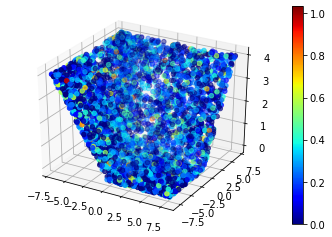

In [25]:
fig = plt.figure()
ax = plt.axes(projection='3d')
p = ax.scatter(noisyMesh[:,0], noisyMesh[:,1], noisyMesh[:,2], c=evaluation, cmap='jet')
fig.colorbar(p)

#ax.plot3D(fullwall1[:,0], fullwall1[:,1], fullwall1[:,2])
#ax.plot3D(fullwall2[:,0], fullwall2[:,1], fullwall2[:,2])
#ax.plot3D(fullwall3[:,0], fullwall3[:,1], fullwall3[:,2])

In [73]:
def evaluatenormals(original, estimate):
    # Calculate the angle difference between the two normals
    size = original.shape[0]
    evaluation = np.zeros(size)

    for i in range(size):
        dot = np.dot(original[i,3:], estimate[i,3:])
        det = np.linalg.norm(original[i,3:]) * np.linalg.norm(estimate[i,3:])
        test = dot / det

        # Ensures that the cos value is valid
        if test > 1.0:
            test = 1.0
        if test < -1.0:
            test = -1.0

        evaluation[i] = np.degrees(np.arccos(test))
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    colours = ax.scatter(noisyMesh[:,0], noisyMesh[:,1], noisyMesh[:,2], c=evaluation, cmap='jet')
    cbar = fig.colorbar(colours, ticks = [0, 2, 4, 6, 8, 10])
    cbar.ax.set_yticklabels(['0', '2', '4', '6', '8', '>10'])

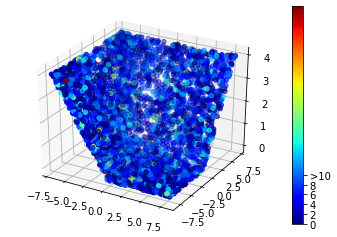

In [72]:
evaluatenormals(noisyMesh,testoutput)

In [45]:
print(noisyMesh)
print(testoutput)

[[ 8.01700252e+00  6.92401333e+00  4.00783915e+00  0.00000000e+00
  -5.00000000e-01  8.66025404e-01]
 [ 3.07321559e+00  3.96935068e+00  2.27959569e+00  0.00000000e+00
  -5.00000000e-01  8.66025404e-01]
 [ 1.80650802e+00  5.37098288e+00  3.10056825e+00  0.00000000e+00
  -5.00000000e-01  8.66025404e-01]
 ...
 [ 2.96946508e+00 -6.16869308e+00  1.52769214e-02  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 7.68011629e+00 -3.34390618e+00 -2.15653950e-03  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 3.51783763e+00 -2.70300345e+00 -5.42310072e-04  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
[[ 8.01700252e+00  6.92401333e+00  4.00783915e+00  0.00000000e+00
  -5.00000000e-01  8.66025404e-01]
 [ 3.07321559e+00  3.96935068e+00  2.27959569e+00 -2.36405642e-02
  -3.67366649e-01  9.34221817e-01]
 [ 1.80650802e+00  5.37098288e+00  3.10056825e+00  0.00000000e+00
  -5.00000000e-01  8.66025404e-01]
 ...
 [ 2.96946508e+00 -6.16869308e+00  1.52769214e-02  1.38303037e-01
  -1.10543451e

In [66]:
angle = np.zeros(noisyMesh.shape[0])

#print(noisyMesh.shape[0])
#print(angle)

for i in range(noisyMesh.shape[0]):
    dot = np.dot(noisyMesh[i,3:], testoutput[i,3:])
    det = np.linalg.norm(noisyMesh[i,3:]) * np.linalg.norm(testoutput[i,3:])
    test = dot / det
    
    #print(dot)
    #print(det)
    
    if test > 1.0:
        test = 1.0
    
    angle[i] = np.degrees(np.arccos(test))
    
print(angle)

[ 0.          8.63881623  0.         ... 10.98620073  6.24240936
  1.94688627]
